In [16]:
# @title 1. Instalação de Bibliotecas
# Instala o dlib (necessário para reconhecimento facial) e outras ferramentas
!pip install face_recognition opencv-python-headless matplotlib

In [17]:
# @title 1. Instalação das Bibliotecas
# Instala o pacote InsightFace e o runtime necessário
!pip install insightface onnxruntime opencv-python matplotlib -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00


In [18]:
# @title 2. Importações e Funções de Visualização
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from IPython.display import clear_output

In [19]:
# @title 2.1. Função para exibir imagem no Colab (converte BGR para RGB)
def mostrar_recorte(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(3, 3))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

print("Bibliotecas e funções auxiliares carregadas.")

Bibliotecas e funções auxiliares carregadas.


In [20]:
# @title 3. Upload e Carregamento da Imagem
print("Faça o upload da foto da turma:")
uploaded = files.upload()

if uploaded:
    nome_arquivo = next(iter(uploaded))
    # Carregando com OpenCV (formato BGR padrão para InsightFace)
    imagem_original = cv2.imread(nome_arquivo)
    print(f"Imagem '{nome_arquivo}' carregada. Dimensões: {imagem_original.shape}")
else:
    print("Nenhum arquivo enviado.")

Faça o upload da foto da turma:


Saving Testando - Copia.jpg to Testando - Copia (5).jpg
Imagem 'Testando - Copia (5).jpg' carregada. Dimensões: (381, 106, 3)


In [21]:
# @title 4. Detecção (Usando RetinaFace via InsightFace)
import insightface
from insightface.app import FaceAnalysis

print("Inicializando o modelo RetinaFace (pode demorar um pouco na 1ª vez)...")

# Inicializa o app. 'buffalo_l' é o modelo robusto (Large)
# providers=['CPUExecutionProvider'] garante que rode mesmo sem GPU configurada
app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640)) # det_size auto-ajustável

# Realiza a inferência
print("Detectando rostos...")
faces_detectados = app.get(imagem_original)

# --- PADRONIZAÇÃO DOS DADOS ---
# Aqui convertemos a saída complexa do InsightFace para uma lista simples
# que a Célula 5 consiga ler sem saber qual IA foi usada.
lista_rostos_padrao = []

for face in faces_detectados:
    # InsightFace retorna bbox como float [x1, y1, x2, y2]
    # Convertemos para inteiros para poder recortar a imagem
    bbox = face.bbox.astype(int)
    x1, y1, x2, y2 = bbox

    # O embedding é a "assinatura" facial (útil para reconhecimento futuro)
    embedding = face.embedding

    # Adicionamos à lista genérica
    lista_rostos_padrao.append({
        'coords': (x1, y1, x2, y2), # Formato: Esquerda, Topo, Direita, Base
        'embedding': embedding
    })

print(f"Sucesso! {len(lista_rostos_padrao)} rostos detectados com alta precisão.")

Inicializando o modelo RetinaFace (pode demorar um pouco na 1ª vez)...
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:07<00:00, 38581.10KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Detectando r

In [23]:
# @title 5. Loop de Identificação (Agnóstico ao Modelo)

# Listas para salvar o "Dataset"
dados_alunos = []

# Cópia para desenho
imagem_final = imagem_original.copy()

print("INICIANDO IDENTIFICAÇÃO...")
print("Pressione ENTER sem digitar nada para pular/marcar como Desconhecido.")

for i, dados in enumerate(lista_rostos_padrao):
    # Desempacota as coordenadas padronizadas
    x1, y1, x2, y2 = dados['coords']

    # Garante que as coordenadas estão dentro da imagem (segurança contra bugs de borda)
    h, w, _ = imagem_original.shape
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)

    # 1. Recorte
    rosto_crop = imagem_original[y1:y2, x1:x2]

    # Verifica se o recorte é válido (tamanho > 0)
    if rosto_crop.size == 0:
        continue

    # 2. Exibição Interativa
    clear_output(wait=True)
    print(f"Rosto {i+1} de {len(lista_rostos_padrao)}")
    mostrar_recorte(rosto_crop)

    # 3. Input
    nome = input("Nome do aluno: ").strip()
    if not nome:
        nome = "Desconhecido"

    # 4. Armazenamento (Nome + Embedding gerado na etapa anterior)
    dados['nome'] = nome
    dados_alunos.append(dados)

    # 5. Desenho na Imagem Final
    # Caixa
    cv2.rectangle(imagem_final, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Fundo do texto
    cv2.rectangle(imagem_final, (x1, y2 - 20), (x2, y2), (0, 255, 0), cv2.FILLED)
    # Texto
    font_scale = max(0.4, (x2 - x1) / 200) # Ajusta tamanho da fonte ao tamanho do rosto
    cv2.putText(imagem_final, nome, (x1 + 2, y2 - 5),
                cv2.FONT_HERSHEY_DUPLEX, font_scale, (0, 0, 0), 1)

clear_output(wait=True)
print("Identificação concluída!")

Identificação concluída!


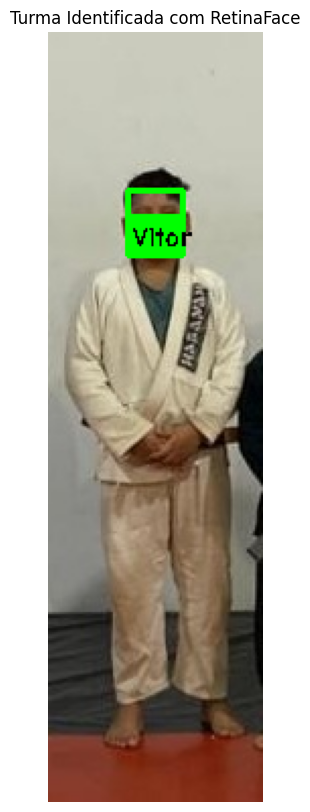


Arquivos gerados:
1. turma_retinaface.jpg (Imagem visual)
2. banco_alunos.pkl (Arquivo de dados para reconhecimento automático futuro)


In [24]:
# @title 6. Visualizar Resultado e Salvar Banco de Dados
import pickle

# 1. Exibir Imagem
img_final_rgb = cv2.cvtColor(imagem_final, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img_final_rgb)
plt.axis('off')
plt.title("Turma Identificada com RetinaFace")
plt.show()

# 2. Salvar Imagem JPG
cv2.imwrite("turma_retinaface.jpg", imagem_final)

# 3. Salvar "Banco de Dados" (Embeddings + Nomes)
# Isso permite que você use esses dados para reconhecer esses alunos em OUTRAS fotos
db_export = []
for item in dados_alunos:
    db_export.append({
        "nome": item['nome'],
        "embedding": item['embedding']
    })

with open('banco_alunos.pkl', 'wb') as f:
    pickle.dump(db_export, f)

print("\nArquivos gerados:")
print("1. turma_retinaface.jpg (Imagem visual)")
print("2. banco_alunos.pkl (Arquivo de dados para reconhecimento automático futuro)")